Configure

In [18]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np 

In [19]:
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 60
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(DEVICE)

cuda


Data Loading Pipelining

In [20]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root = './data', train = True, download = True , transform = transform)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE , shuffle = True )

test_dataset = datasets.CIFAR10(root = './data' , download = True , train = False , transform = transform)
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE , shuffle = False)

Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self , latent_dim):
        super(Encoder, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d( in_channels = 3 , out_channels=32 , kernel_size = 3 , stride = 2 , padding =1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d( in_channels = 32 , out_channels = 64 , kernel_size = 3 , stride = 2 , padding = 1 ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels = 64 , out_channels = 128 , kernel_size = 3 , stride = 2 , padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels = 128 , out_channels = 256 , kernel_size = 3 , stride = 2 , padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)

        )

        self.flatten_size  = 256 *2 *2

        self.fc_mu = nn.Linear(self.flatten_size , latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size , latent_dim)


    def forward(self,x):
        x =  self.convs(x)
        x =  torch.flatten(x, start_dim = 1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu , logvar


Decoder

In [22]:
class Decoder(nn.Module):
    def __init__(self , latent_dim):
        super(Decoder, self).__init__()

        self.flatten_size = 256 *2 *2
        self.fc_input = nn.Linear(latent_dim , self.flatten_size)

        self.deconvs = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256 , out_channels = 128 , kernel_size = 3 , stride = 2 , padding = 1 , output_padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels = 128 , out_channels = 64 , kernel_size = 3 , stride = 2 , padding = 1 , output_padding =1 ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels = 64 , out_channels = 32 , kernel_size = 3 , stride = 2 , padding =1 , output_padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d( in_channels = 32 , out_channels = 3 , kernel_size = 3 , stride = 2 , padding = 1 , output_padding = 1),
            nn.Sigmoid()

        )

    def forward( self , z):

        x = self.fc_input(z)
        x = x.view(-1 , 256 , 2, 2)
        recons = self.deconvs(x)

        return recons

Variational Auto Encoder

In [23]:
class VAE (nn.Module):
    def __init__(self , latent_dim):
        super(VAE , self).__init__()

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparamatariztion(self , mu , logvar):

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        z = mu + eps * std
        return z
    
    def forward(self , x):
         mu , logvar = self.encoder(x)
         z = self.reparamatariztion(mu, logvar)
         recons = self.decoder(z)
         return recons , mu , logvar



Loss Function

In [24]:
def VAE_loss(recon_x , x , mu , logvar):

    MSE = F.mse_loss(recon_x , x , reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

Training Loop

In [25]:
model = VAE(latent_dim = LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters() , lr = LR)

In [26]:
def train(model , device , train_loader , optimizer , epoch):
    model.train()
    train_loss = 0

    for batch_idx , (data,_) in enumerate(train_loader):

        data = data.to(device)

        optimizer.zero_grad()

        recon_batch , mu , logvar = model(data)  
        loss = VAE_loss(recon_batch , data , mu , logvar)

        loss.backward()

        train_loss += loss.item()

        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch , batch_idx * len(data) , len(train_loader.dataset) ,
                100. * batch_idx / len(train_loader) ,
                loss.item() / len(data)
            ))
    
    print(f"Epoch {epoch} Avg Loss : {train_loss / len(train_loader.dataset):.4f}")

for epoch in range(1 , EPOCHS + 1):
    train(model , DEVICE , train_loader , optimizer , epoch)



Train Epoch: 1 [0/50000 (0%)]	Loss: 281.639221
Train Epoch: 1 [6400/50000 (13%)]	Loss: 126.551102
Train Epoch: 1 [12800/50000 (26%)]	Loss: 101.242691
Train Epoch: 1 [19200/50000 (38%)]	Loss: 103.904221
Train Epoch: 1 [25600/50000 (51%)]	Loss: 97.619286
Train Epoch: 1 [32000/50000 (64%)]	Loss: 97.154121
Train Epoch: 1 [38400/50000 (77%)]	Loss: 86.547546
Train Epoch: 1 [44800/50000 (90%)]	Loss: 80.993866
Epoch 1 Avg Loss : 102.0475
Train Epoch: 2 [0/50000 (0%)]	Loss: 86.465500
Train Epoch: 2 [6400/50000 (13%)]	Loss: 79.412903
Train Epoch: 2 [12800/50000 (26%)]	Loss: 78.861771
Train Epoch: 2 [19200/50000 (38%)]	Loss: 83.530815
Train Epoch: 2 [25600/50000 (51%)]	Loss: 87.043144
Train Epoch: 2 [32000/50000 (64%)]	Loss: 84.870285
Train Epoch: 2 [38400/50000 (77%)]	Loss: 82.872261
Train Epoch: 2 [44800/50000 (90%)]	Loss: 77.913132
Epoch 2 Avg Loss : 82.2449
Train Epoch: 3 [0/50000 (0%)]	Loss: 83.285179
Train Epoch: 3 [6400/50000 (13%)]	Loss: 79.115303
Train Epoch: 3 [12800/50000 (26%)]	Loss: 

Visualization

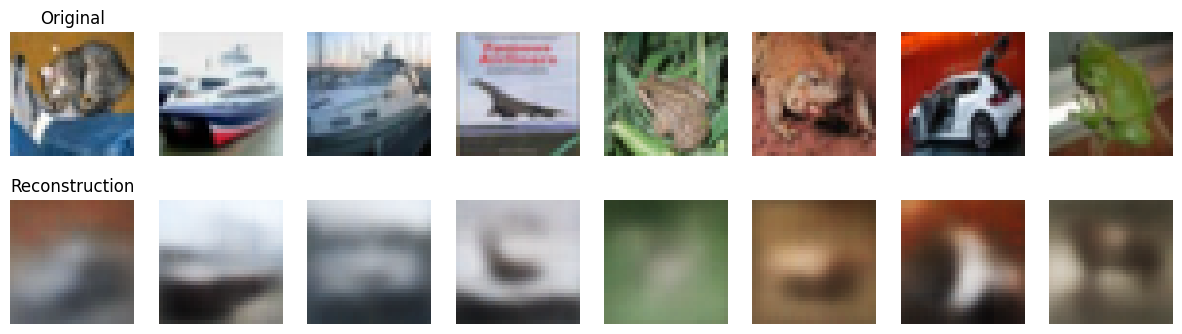

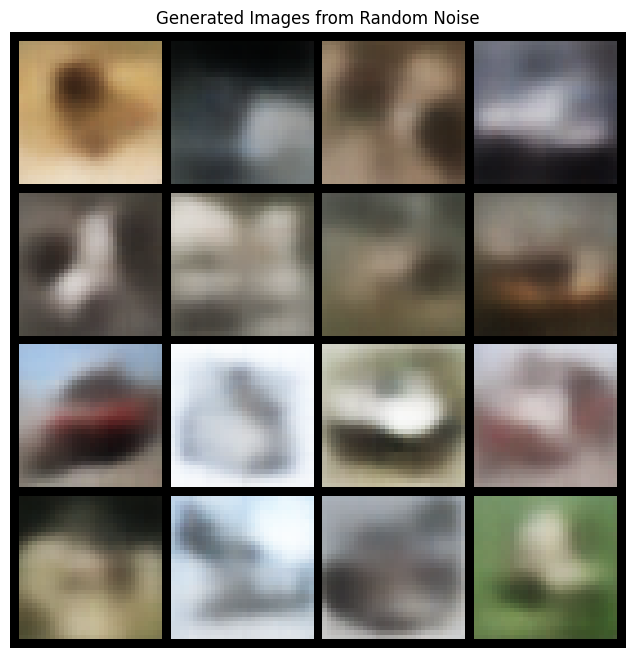

In [28]:
def visualize_results(model, test_loader):
    model.eval()
    
    # Get one batch of test images
    data, _ = next(iter(test_loader))
    data = data.to(DEVICE)
    
    # Reconstruct
    with torch.no_grad():
        recon, _, _ = model(data)
    
    # Move to CPU for plotting
    data = data.cpu()
    recon = recon.cpu()
    
    # Plot Original vs Reconstructed
    n = 8  # How many images to display
    plt.figure(figsize=(15, 4))
    for i in range(n):
        # Display Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].permute(1, 2, 0))
        plt.axis("off")
        if i == 0: ax.set_title("Original")

        # Display Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i].permute(1, 2, 0))
        plt.axis("off")
        if i == 0: ax.set_title("Reconstruction")
    plt.show()

def generate_new_images(model, num_images=16):
    model.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_images, LATENT_DIM).to(DEVICE)
        generated = model.decoder(z).cpu()
        
        grid_img = torchvision.utils.make_grid(generated, nrow=4)
        plt.figure(figsize=(8,8))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis('off')
        plt.title("Generated Images from Random Noise")
        plt.show()

# Run visualization
visualize_results(model, test_loader)
generate_new_images(model)